# Redes Bayesianas Discretas: Introducción a Bnlearn

Master in Data Science - Machine Learning II

Santander Meteorology Group,

Profesor: Mikel N. Legasa (legasam@unican.es)

6 Mar 2018

La presente práctica esta concebida como una primera aproximación a los fundamentos de las redes bayesianas, encargándonos simplemente de la modelización de variables discretas mediante una red bayesiana siguiendo el esquema:

  - [Introducción](#1-Introducción)
  - [Construcción de la red bayesiana](#2-Construcción-de-la-Red-Bayesiana), tanto su estructura (Construcción del DAG) y sus parámetros (Construcción de las tablas de probabilidad condicionada)
  - Obtención de información cualitativa a partir del grafo (Consultas al grafo).

Con la idea de familiarizarnos con la librería bnlearn y sus estructuras y funciones.

## 1 Introducción

### 1.1 Dataset de ejemplo: ‘survey’

Utilizaremos los datos de una encuesta sobre utilización de medios de transporte, donde cada variable tiene un número finito de posibles estados. A partir de los datos de campo recogidos por la encuesta, se investigará la selección de medios de transporte por distintos perfiles de usuarios, y particularmente la preferencia de tren o coche. Este tipo de análisis se utiliza con frecuencia en la planificación de infraestructuras. Para cada individuo encuestado, se han recopilado datos referentes a 6 variables discretas. Las abreviaturas de dichas variables se muestran entre paréntesis (original del dataset en inglés), y se utilizarán a lo largo de la práctica para referirse a los nodos de la red creada.

  - Edad (A): Edad del encuestado: joven (young, < 30 años), adulto (adult, 30 < edad <= 60) y anciano (old, edad > 60).
  - Sexo (S): Sexo del encuestado: masculino (M) y femenino (F).
  - Educación (E): Nivel más alto de educación alcanzado: Hasta educación secundaria (high) o título universitario (uni).
  - Ocupación (O): trabajador por cuenta ajena (emp) o autónomo (self).
  - Residencia (R): Tamaño de la población de residencia del individuo: big y small.
  - Transporte (T): Medio de transporte más utilizado por el encuestado para acudir al trabajo: car, train y other.

### 1.2 Paquetes de R necesarios

Se utilizará el paquete de R bnlearn (bayesian network learning), disponible a través de CRAN:

```r
install.packages("bnlearn")
```

Además, se necesitan dependencias adicionales que no están en CRAN, sinó en Bioconductor:

```r
# (bioconductor)
source("http://bioconductor.org/biocLite.R")

# Para la inferencia
biocLite("RBGL")
# Para la parte de visualización de grafos:
biocLite("Rgraphviz")
# Para manejo de grafos:
# Paquete gRain
install.packages("gRain")
```

In [1]:
#::GMG::Yo ya instalé esos paquetes en la sesión lab de introducción
#       Ahora cargo la biblioteca que necesito
library('bnlearn')


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma



## 2 Construcción de la Red Bayesiana

### 2.1 Construcción del DAG

Para estos datos trataremos de [construir manualmente un grafo](http://www.bnlearn.com/examples/dag/) que verifique $⊥_G ⇒ ⊥_P$, tratando de definir las dependencias e independencias que consideremos intuitivamente que se dan entre las variables, con el objetivo final de modelizar los datos, i.e. de aproximar la Distribución de Probabilidad Conjunta de los datos $P$.

Para crear un grafo que contenga un nodo por cada variable considerada en la encuesta utilizamos la función [`empty.graph()`](http://www.bnlearn.com/documentation/man/graphgen.html), que pertenece a *bnlearn* e inicializa un grafo vacío como clase bn:

In [2]:
#::GMG::Creo de forma "experta" (custom) el dag de survey
# http://www.bnlearn.com/examples/dag/
#::nota::el orden de los nodos es relevante en la visualización
#        ya que aparecen en el orden en que aparecen en el dataset
# A		R	E	O	S	T
dag <- empty.graph(nodes = c("A", "R", "E", "O", "S", "T"))
class(dag)

[1] "bn"

Nombramos a nuestro grafo vacío `dag` (*directed acyclic graph*). Esta es la información contenida en el grafo:

In [3]:
print(dag)


  Random/Generated Bayesian network

  model:
   [A][R][E][O][S][T] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 



Este objeto se organiza como una lista, de manera que podemos acceder a sus elementos mediante `dag$learning`, etc…

In [4]:
#::GMG::Pruebo esa estructura (me puede ser útil en el futuro)
# http://www.bnlearn.com/documentation/man/bn.fit.class.html
dag$learning

$whitelist
NULL

$blacklist
NULL

$test
[1] "none"

$ntests
[1] 0

$algo
[1] "empty"

$args
list()

In [5]:
#::GMG::Cada nodo contiene el nombre, markov blanket,
#       neighborhood, parents y children
dag$nodes

$A
$A$mb
character(0)

$A$nbr
character(0)

$A$parents
character(0)

$A$children
character(0)


$R
$R$mb
character(0)

$R$nbr
character(0)

$R$parents
character(0)

$R$children
character(0)


$E
$E$mb
character(0)

$E$nbr
character(0)

$E$parents
character(0)

$E$children
character(0)


$O
$O$mb
character(0)

$O$nbr
character(0)

$O$parents
character(0)

$O$children
character(0)


$S
$S$mb
character(0)

$S$nbr
character(0)

$S$parents
character(0)

$S$children
character(0)


$T
$T$mb
character(0)

$T$nbr
character(0)

$T$parents
character(0)

$T$children
character(0)

In [6]:
#::GMG::De momento no hay definido ningún arco 
dag$arcs

from,to


En secciones posteriores veremos como hacer representaciones gráficas más detalladas, pero de momento basta con aplicar `plot()` para ir viendo la estructura básica de la red. Una vez creados los nodos, comenzamos a añadir los arcos que definen las dependencias directas entre las diferentes variables y que parezcan razonables.

La *edad* y el *sexo* son indicadores demográficos y no reciben influencia de ninguna otra variable, ya que son características intrínsecas del individuo. Por lo tanto, *ninguno de los arcos del grafo apuntan hacia ellas*.

Por otra parte, parece razonable que ambas variables (sexo y edad) *tengan una influencia directa sobre el nivel de educación*, ya que el número de estudiantes universitarios ha aumentado en las últimas décadas, y por lo tanto personas más jóvenes tienen más probabilidad de tener un título universitario que otras más mayores:

In [7]:
#::GMG::establecer un arco significa que NO hay independencia (a priori)
dag <- set.arc(dag, from = "A", to = "E")

Del mismo modo, el sexo tiene influencia sobre la educación, ya que las estadísticas demuestran que en la actualidad hay un mayor número de mujeres que de hombres completando estudios universitarios:

In [8]:
dag <- set.arc(dag, from = "S", to = "E")

In [9]:
#::GMG::Ya tengo los primeros arcos dirigidos en el grafo
dag$arcs

from,to
A,E
S,E


In [10]:
#::GMG::Los nodos implicados tienen padres e hijos
dag$nodes$A

$mb
[1] "E" "S"

$nbr
[1] "E"

$parents
character(0)

$children
[1] "E"

In [11]:
dag$nodes$E

$mb
[1] "A" "S"

$nbr
[1] "A" "S"

$parents
[1] "A" "S"

$children
character(0)

Tras añadir dos arcos, este es el aspecto que va tomando el grafo:

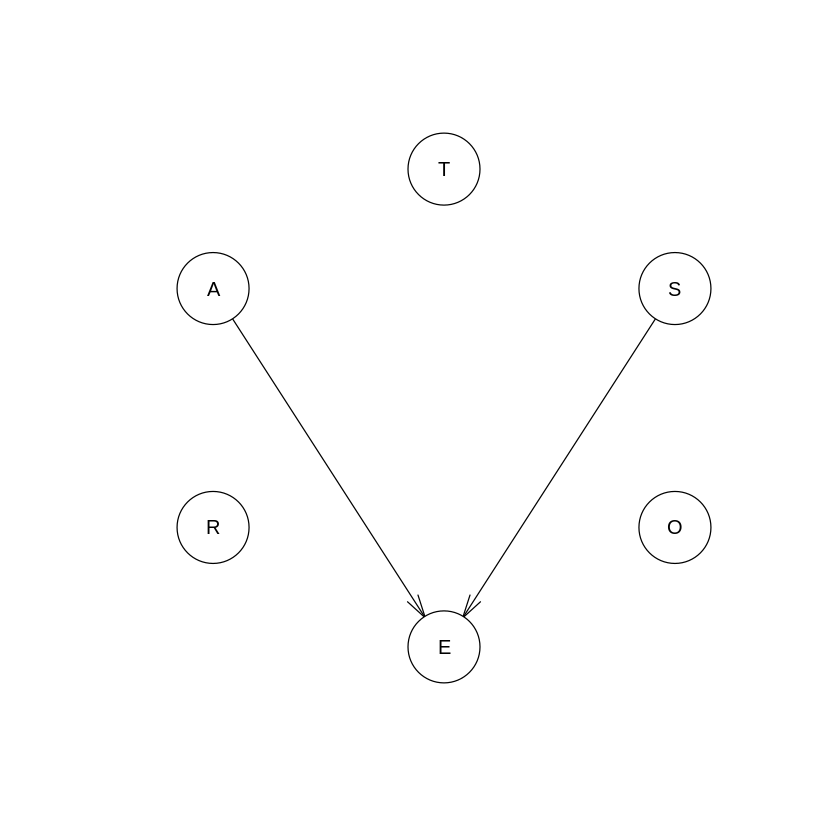

In [12]:
plot(dag)

In [7]:
# la presencia de unidrected arcs es debida a que cuando se aprende el grafo
# ciertas relaciones no tienen por qué estar dirigidas y el que modela define
# la dirección según su conocimiento a priori del dominio del problema
# ::nota::esa conexión, da igual cuál sea la dirección, es equivalente
# (en factorización)
print(dag)


  Random/Generated Bayesian network

  model:
   [A][R][O][S][T][E|A:S] 
  nodes:                                 6 
  arcs:                                  2 
    undirected arcs:                     0 
    directed arcs:                       2 
  average markov blanket size:           1.00 
  average neighbourhood size:            0.67 
  average branching factor:              0.33 

  generation algorithm:                  Empty 



In [8]:
dag <- set.arc(dag, from = "E", to = "O") 

In [9]:
dag <- set.arc(dag, from = "E", to = "R")

In [10]:
dag <- set.arc(dag, from = "R", to = "T")

In [11]:
dag <- set.arc(dag, from = "O", to = "T")

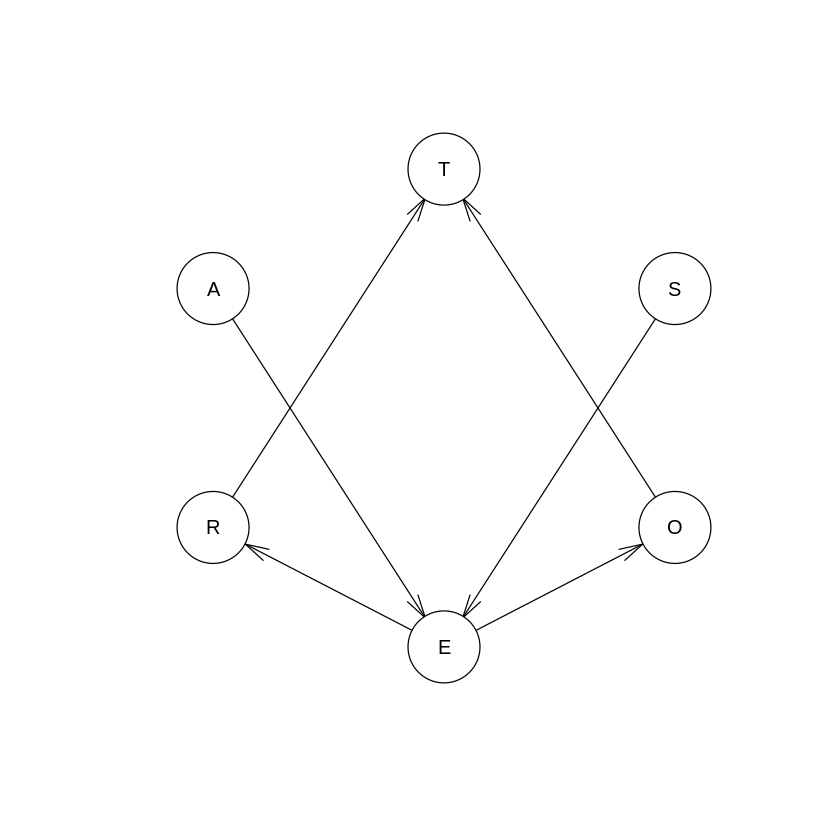

In [12]:
plot(dag)

In [13]:
# factorización de la probabilidad conjunta
modelstring(dag)

[1] "[A][S][E|A:S][R|E][O|E][T|R:O]"

In [16]:
#estructura del grafo
nodes(dag)

[1] "A" "S" "E" "O" "R" "T"

In [17]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
R,T
O,T


In [21]:
# toda modificación de los grafos hay que hacerlas con las funciones de bnlearn
# no tocando directamente las estructuras
dag$arcs

from,to
A,E
S,E
E,O
E,R
R,T
O,T


In [22]:
# estado de los nodos y la tabla de probabilidad
estados.A <- c("young", "adult", "old")
estados.S <- c("M", "F")
estados.E <- c("high", "uni")
estados.O <- c("emp","self")
estados.R <- c("small","big")
estados.T <- c("car","train","other")

In [24]:
estados.A

[1] "young" "adult" "old"

In [27]:
A.prob <- array(data = c(.3, .5, .2), dim = 3, dimnames = list(A = estados.A))

In [ ]:
A.prob

In [33]:
S.prob <- array(c(.6, .4), dim = 2, dimnames = list(S = estados.S))

In [ ]:
S.prob

In [28]:
O.prob <- array(c(.96,.04,.92,.08), dim = c(2,2), dimnames = list(O = estados.O, E = estados.E))

In [ ]:
O.prob

In [29]:
R.prob <- array(c(.25,.75,.2,.8), dim = c(2,2), 
                  dimnames = list(R = estados.R, E = estados.E))

In [ ]:
R.prob

In [30]:
E.prob <- array(c(.75, .25, .72, .28, .88, .12, .64, .36, .70, .30, .90, .10),
                dim = c(2, 3, 2),
                dimnames = list(E = estados.E,
                                A = estados.A,
                                S = estados.S))

In [ ]:
E.prob (1,,)

In [31]:
T.prob <- array(c(.48, .42, .1, .56, .36, .08, .58, .24, .18, .7, .21, .09),
                dim = c(3,2,2),
                dimnames = list(T = estados.T, 
                                O = estados.O,
                                R = estados.R))

In [ ]:
T.prob

In [35]:
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)

In [36]:
bn <- custom.fit(x = dag, dist = cpt)

In [37]:
# http://www.bnlearn.com/documentation/man/bn.class.html
# http://www.bnlearn.com/documentation/man/bn.fit.class.html
class(bn)

[1] "bn.fit"      "bn.fit.dnet"

In [26]:
# consultas al grafo (no de inferencia)
# x -> y -> z => P(x)p(y/x)p(z/y); x <- y -> z => P(y) p(x/y) P(z/y)
# d-separation => independence becasuse it's an I-graph 
# en el ejercicio 

In [38]:
nbr(dag, "O")

[1] "E" "T"

In [39]:
mb(dag, "O")

[1] "E" "R" "T"

In [43]:
#ejercicio 2: añadir un arco de A a T
dag <- set.arc(dag,from = 'A', to = 'T')

In [44]:
mb(dag, "O")

[1] "A" "E" "R" "T"

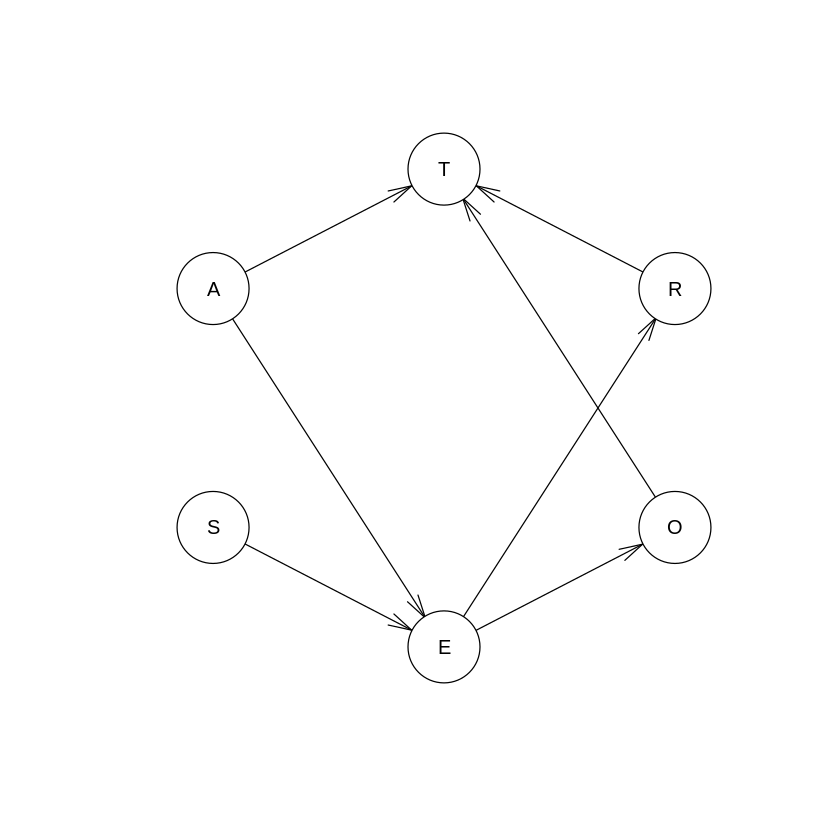

In [45]:
plot(dag)

In [ ]:
# ¿se ha creado una nueva independencia?
# dsep (A, O) dado E; dsep(A, O) dado E,T (E=e, T = t); al añadir A -> T NO se cumple los dsep
#::nota:: iq -> nota <- dif => iq not dsep | nota

In [46]:
dsep(bn = dag, x = 'A' , y = 'O', z = c('E', 'T'))

[1] FALSE

In [47]:
dag <- drop.arc(dag,from = 'A', to = 'T')

In [48]:
dsep(bn = dag, x = 'A' , y = 'O', z = c('E', 'T'))

[1] TRUE

In [ ]:
# en el apartado 3 hay que poner la factorización nueva com p(A/T) como factor
# Z ind U NO
# Z dependiente U no es seguro
# T ind U NO
# T ind U|R SI
# Z ind U |T SI
# Z ind U | T, E SI
# Z ind U | X NO
# ...
# K ind T SI v-structura y no evidenciado (R)
# K ind Z SI
